# Del 5: Procesiranje velikih datasetov v pandas-u

Pripravimo datasete:

In [1]:
!tar -xJf data/data_del_05.tar.xz -C ./data/

Viri:
- [Tutorial: Using Pandas with Large Data Sets in Python](https://www.dataquest.io/blog/pandas-big-data/)
- [How to handle large datasets in Python with Pandas and Dask](https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55)
- [Why is Python so slow?](https://hackernoon.com/why-is-python-so-slow-e5074b6fe55b)
- [Why Python is Slow: Looking Under the Hood](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)
- [Make working with large DataFrames easier, at least for your memory](https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4)
- [“Large data” work flows using pandas](https://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas)
- [Why and How to Use Pandas with Large Data](https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c)
- [4 Strategies to Deal With Large Datasets Using Pandas](https://www.codementor.io/guidotournois/4-strategies-to-deal-with-large-datasets-using-pandas-qdw3an95k)

## Introduction & Data

We'll be working with data on the Museum of Modern Art's exhibitions. More specifically, we'll use the file `MoMAExhibitions1929to1989.csv`, which you can download from [data.world](https://data.world/moma/exhibitions). Dataset se poveča za 4 - 8x, ko ga naložimo v pomnilnik.

In [2]:
import pandas as pd
import numpy as np

In [3]:
moma = pd.read_csv('data/MoMAExhibitions1929to1989.csv')

In [4]:
moma.head(2)

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ConstituentID,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Director,9168.0,...,NaN,American,1902.0,1981.0,"American, 1902–1981",Male,109252853.0,Q711362,500241556.0,moma.org/artists/9168
1,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Artist,1053.0,...,NaN,French,1839.0,1906.0,"French, 1839–1906",Male,39374836.0,Q35548,500004793.0,moma.org/artists/1053


In [5]:
#spodaj dobimo podatek o zasedenem pomnilniku - je samo približek -> ne vrne dodatne tabele pri stringih, ki povezuje
#stringe z kazalci na mesto v pomnilniku
moma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
ExhibitionID              34129 non-null float64
ExhibitionNumber          34558 non-null object
ExhibitionTitle           34558 non-null object
ExhibitionCitationDate    34557 non-null object
ExhibitionBeginDate       34558 non-null object
ExhibitionEndDate         33354 non-null object
ExhibitionSortOrder       34558 non-null float64
ExhibitionURL             34125 non-null object
ExhibitionRole            34424 non-null object
ConstituentID             34044 non-null float64
ConstituentType           34424 non-null object
DisplayName               34424 non-null object
AlphaSort                 34424 non-null object
FirstName                 31499 non-null object
MiddleName                3804 non-null object
LastName                  31998 non-null object
Suffix                    157 non-null object
Institution               2458 non-null object
Nationality               26

## Optimizing Dataframe Memory Footprint

### The Internal Representation of a Dataframe

<img src="./images/pandas_dataframe_blocks.png">

In [6]:
#podatki se shranijo v 2 skupini - object in float

In [7]:
#pokaze kako so shranjeni podatki v block managerju
moma._data

BlockManager
Items: Index(['ExhibitionID', 'ExhibitionNumber', 'ExhibitionTitle',
       'ExhibitionCitationDate', 'ExhibitionBeginDate', 'ExhibitionEndDate',
       'ExhibitionSortOrder', 'ExhibitionURL', 'ExhibitionRole',
       'ConstituentID', 'ConstituentType', 'DisplayName', 'AlphaSort',
       'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution',
       'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate',
       'ArtistBio', 'Gender', 'VIAFID', 'WikidataID', 'ULANID',
       'ConstituentURL'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=34558, step=1)
FloatBlock: [0, 6, 9, 19, 20, 23, 25], 7 x 34558, dtype: float64
ObjectBlock: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 26], 20 x 34558, dtype: object

### Dataframe Memory Footprint

#### Float Columns

In [10]:
#stevilo vrstic * 8 (64 bitna številka) = stevilo B v stolpcu
34558*8

276464

In [9]:
#ali na ta način:
moma['ExhibitionID'].nbytes

276464

In [11]:
#v MB
276464/(1024*1024)

0.2636566162109375

#### Object Columns

<img src="./images/numpy_vs_python.png">

#### True Memory Footprint

In [13]:
# .size vrne število "celic" v dataframeu
total_bytes = moma.size * 8

In [15]:
total_megabytes = total_bytes /(1024*1024)
total_megabytes

7.1187286376953125

In [16]:
print('Total bytes: ', total_bytes)
print('Total megabytes: ', total_megabytes)

Total bytes:  7464528
Total megabytes:  7.1187286376953125


In [17]:
#na ta nacin vidimo koliko tocno pomnilnika porabi
moma.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
ExhibitionID              34129 non-null float64
ExhibitionNumber          34558 non-null object
ExhibitionTitle           34558 non-null object
ExhibitionCitationDate    34557 non-null object
ExhibitionBeginDate       34558 non-null object
ExhibitionEndDate         33354 non-null object
ExhibitionSortOrder       34558 non-null float64
ExhibitionURL             34125 non-null object
ExhibitionRole            34424 non-null object
ConstituentID             34044 non-null float64
ConstituentType           34424 non-null object
DisplayName               34424 non-null object
AlphaSort                 34424 non-null object
FirstName                 31499 non-null object
MiddleName                3804 non-null object
LastName                  31998 non-null object
Suffix                    157 non-null object
Institution               2458 non-null object
Nationality               26

> **index** : *bool, default True* --> 
Specifies whether to include the memory usage of the DataFrame’s index in returned Series. If index=True, the memory usage of the index is the first item in the output.

In [18]:
moma.memory_usage(deep=True, index=False)

ExhibitionID               276464
ExhibitionNumber          2085850
ExhibitionTitle           3333695
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionSortOrder        276464
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentID              276464
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104929
MiddleName                1218953
LastName                  2162941
Suffix                    1110349
Institution               1221368
Nationality               1949664
ConstituentBeginDate       276464
ConstituentEndDate         276464
ArtistBio                 3183300
Gender                    1858994
VIAFID                     276464
WikidataID                1821293
ULANID                     276464
ConstituentURL            2677922
dtype: int64

In [19]:
def get_memory_usage_by_type(df, types=[]):
    if not types:
        types = []
        for column in df.columns:
            if hasattr(df[column], 'cat'):
                types.append('category')
            else:
                types.append(df[column].dtype)
        types = list(set(types))
    total = 0
    for dtype in types:
        selected_dtype = df.select_dtypes(include=[dtype])
        num_of_columns = len(selected_dtype.columns)
        mean_usage_b = selected_dtype.memory_usage(deep=True, index=False).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        sum_usage_b = selected_dtype.memory_usage(deep=True, index=False).sum()
        sum_usage_mb = sum_usage_b / 1024 ** 2
        print(f"Average memory usage: {round(mean_usage_mb, 3)} MB and total: {round(sum_usage_mb, 3)} MB for {num_of_columns}x {dtype} columns.")
        total += sum_usage_mb
        
    print('----------------------')
    print(f'Total memory usage: {round(total, 3)} MB')

In [20]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


### Optimizing Numeric Columns with Subtypes

<table>
<thead>
<tr>
<th>memory usage</th>
<th>float</th>
<th>int</th>
<th>uint</th>
<th>datetime</th>
<th>bool</th>
<th>object</th>
</tr>
</thead>
<tbody>
<tr>
<td>1 bytes</td>
<td></td>
<td>int8</td>
<td>uint8</td>
<td></td>
<td>bool</td>
<td></td>
</tr>
<tr>
<td>2 bytes</td>
<td>float16</td>
<td>int16</td>
<td>uint16</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>4 bytes</td>
<td>float32</td>
<td>int32</td>
<td>uint32</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>8 bytes</td>
<td>float64</td>
<td>int64</td>
<td>uint64</td>
<td>datetime64</td>
<td></td>
<td></td>
</tr>
<tr>
<td>variable</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>object</td>
</tr>
</tbody>
</table>

In [22]:
int_types = ["int8", "int16", "int32", "int64"]

#prikaže max in min vrednosti, ki jih lahko posamezni tip prikaže
for i in int_types:
    print(np.iinfo(i))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



#### Integer Columns

In [23]:
moma.head()

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ConstituentID,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Director,9168.0,...,NaN,American,1902.0,1981.0,"American, 1902–1981",Male,109252853.0,Q711362,500241556.0,moma.org/artists/9168
1,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Artist,1053.0,...,NaN,French,1839.0,1906.0,"French, 1839–1906",Male,39374836.0,Q35548,500004793.0,moma.org/artists/1053
2,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Artist,2098.0,...,NaN,French,1848.0,1903.0,"French, 1848–1903",Male,27064953.0,Q37693,500011421.0,moma.org/artists/2098
3,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Artist,2206.0,...,NaN,Dutch,1853.0,1890.0,"Dutch, 1853–1890",Male,9854560.0,Q5582,500115588.0,moma.org/artists/2206
4,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1.0,http://www.moma.org/calendar/exhibitions/1767,Artist,5358.0,...,NaN,French,1859.0,1891.0,"French, 1859–1891",Male,24608076.0,Q34013,500008873.0,moma.org/artists/5358


In [26]:
moma.select_dtypes(include=['float']).isnull().sum()

ExhibitionID              429
ExhibitionSortOrder         0
ConstituentID             514
ConstituentBeginDate     9268
ConstituentEndDate      14739
VIAFID                   7562
ULANID                  12870
dtype: int64

In [28]:
#vidimo, da lahko vse floate pretvorimo v intigerje; prej moramo preveriti, da ni NaN ali podobnih vrednosti
moma['ExhibitionSortOrder'].astype('int').head()

0    1
1    1
2    1
3    1
4    1
Name: ExhibitionSortOrder, dtype: int64

In [29]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
moma.select_dtypes(include=['float']).head()

,ExhibitionID,ExhibitionSortOrder,ConstituentID,ConstituentBeginDate,ConstituentEndDate,VIAFID,ULANID
0,2557.0,1.0,9168.0,1902.0,1981.0,109252853.0,500241556.0
1,2557.0,1.0,1053.0,1839.0,1906.0,39374836.0,500004793.0
2,2557.0,1.0,2098.0,1848.0,1903.0,27064953.0,500011421.0
3,2557.0,1.0,2206.0,1853.0,1890.0,9854560.0,500115588.0
4,2557.0,1.0,5358.0,1859.0,1891.0,24608076.0,500008873.0


In [30]:
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


In [32]:
# Function to convert to best integer subtype
def convert_col_to_best_int_subtype(df, columns=[]):
    for column in columns:
        col_max = df[column].max()
        col_min = df[column].min()
        
        if col_max < np.iinfo('int8').max and col_min > np.iinfo('int8').min:
            df[column] = df[column].astype('int8')
        elif col_max <  np.iinfo("int16").max and col_min > np.iinfo("int16").min:
            df[column] = df[column].astype("int16")
        elif col_max <  np.iinfo("int32").max and col_min > np.iinfo("int32").min:
            df[column] = df[column].astype("int32")
        elif col_max <  np.iinfo("int64").max and col_min > np.iinfo("int64").min:
            df[column] = df[column].astype("int64")

In [33]:
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])

In [34]:
moma.dtypes.value_counts()

object     20
float64     6
int16       1
dtype: int64

In [35]:
#novi stolpec porabi približno 4x manj kot prejšnji
get_memory_usage_by_type(moma)

Average memory usage: 0.264 MB and total: 1.582 MB for 6x float64 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.415 MB


#### Float Columns

In [38]:
#80 dodamo za index stolpec
value_bytes = len(moma) * 2 + 80
value_bytes == moma['ExhibitionSortOrder'].memory_usage(deep=True)

True

In [39]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int')
moma['ExhibitionSortOrder'].dtype

dtype('int64')

In [40]:
# Reset the dataframe to the original CSV, zmanjšamo velikost stolpca kot je primerno glede na podatke v stolpcu
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int')
moma['ExhibitionSortOrder'] = pd.to_numeric(moma['ExhibitionSortOrder'], downcast='integer')


moma['ExhibitionSortOrder'].dtype

dtype('int16')

In [41]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
get_memory_usage_by_type(moma)    

Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 45.613 MB


In [44]:
# convert int columns
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])

# convert folat columns
float_cols = moma.select_dtypes(include=['float'])
for col in float_cols.columns:
    moma[col] = pd.to_numeric(moma[col], downcast='float')

In [45]:
moma.dtypes.value_counts()

object     20
float32     6
int16       1
dtype: int64

In [46]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.188 MB and total: 43.768 MB for 20x object columns.
----------------------
Total memory usage: 44.624 MB


### Converting To DateTime

In [47]:
moma['ExhibitionBeginDate'] = pd.to_datetime(moma['ExhibitionBeginDate'])
moma['ExhibitionEndDate'] = pd.to_datetime(moma['ExhibitionEndDate'])

In [48]:
moma.dtypes.value_counts()

object            18
float32            6
datetime64[ns]     2
int16              1
dtype: int64

In [49]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.192 MB and total: 39.46 MB for 18x object columns.
Average memory usage: 0.264 MB and total: 0.527 MB for 2x datetime64[ns] columns.
----------------------
Total memory usage: 40.844 MB


### Converting to Categorical

In [50]:
moma['ConstituentType'].unique()

array(['Individual', nan, 'Institution'], dtype=object)

In [51]:
#zdaj vsakega od teh dveh stringov vsakič zapišemo v vrstico
#raje ju bomo kategorizirali in zapisali samo 2x, ostalo pa povezali z 8bit int
moma['ConstituentType'].value_counts()

Individual     32008
Institution     2416
Name: ConstituentType, dtype: int64

In [52]:
moma['ConstituentType'].memory_usage(deep=True) / (1024*1024)

2.2060317993164062

In [53]:
moma['ConstituentType'].astype('category').memory_usage(deep=True) / (1024*1024)

0.03323841094970703

In [54]:
obj_col = moma.select_dtypes(include=['object'])

In [55]:
for col in obj_col.columns:
    num_unique_values = len(moma[col].unique())
    num_total_values = len(moma[col])
    
    if num_unique_values / num_total_values < 0.5:
        moma[col] = moma[col].astype('category')
    
    

In [56]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.791 MB for 6x float32 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 0.419 MB and total: 7.54 MB for 18x category columns.
Average memory usage: 0.264 MB and total: 0.527 MB for 2x datetime64[ns] columns.
----------------------
Total memory usage: 8.924 MB


## Selecting Types While Reading the Data In

### Example: MoMA dataset

In [57]:
#če niti ne moremo naložiti dataseta v pomnilnik, najprej preberemo samo nekaj vrstic
moma_sample = pd.read_csv("data/MoMAExhibitions1929to1989.csv", nrows=3)

In [58]:
moma_sample

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ConstituentID,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Director,9168,...,NaN,American,1902,1981,"American, 1902–1981",Male,109252853,Q711362,500241556,moma.org/artists/9168
1,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Artist,1053,...,NaN,French,1839,1906,"French, 1839–1906",Male,39374836,Q35548,500004793,moma.org/artists/1053
2,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Artist,2098,...,NaN,French,1848,1903,"French, 1848–1903",Male,27064953,Q37693,500011421,moma.org/artists/2098


In [59]:
moma_sample.columns.to_list()

['ExhibitionID',
 'ExhibitionNumber',
 'ExhibitionTitle',
 'ExhibitionCitationDate',
 'ExhibitionBeginDate',
 'ExhibitionEndDate',
 'ExhibitionSortOrder',
 'ExhibitionURL',
 'ExhibitionRole',
 'ConstituentID',
 'ConstituentType',
 'DisplayName',
 'AlphaSort',
 'FirstName',
 'MiddleName',
 'LastName',
 'Suffix',
 'Institution',
 'Nationality',
 'ConstituentBeginDate',
 'ConstituentEndDate',
 'ArtistBio',
 'Gender',
 'VIAFID',
 'WikidataID',
 'ULANID',
 'ConstituentURL']

In [60]:
keep_cols = ['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 
             'ExhibitionEndDate', 'ExhibitionSortOrder', 'ExhibitionRole', 
             'ConstituentType', 'DisplayName', 'Institution', 'Nationality', 
             'Gender']

In [61]:
col_types = {'ExhibitionID': np.float32, 
             'ExhibitionNumber': 'category',
             'ExhibitionSortOrder': np.float16, 
             'ExhibitionRole': 'category', 
             'ConstituentType' : 'category', 
             'DisplayName' : 'category', 
             'Institution': 'category',  
             'Nationality' : 'category', 
             'Gender': 'category'}

In [62]:
date_cols = ["ExhibitionBeginDate", "ExhibitionEndDate"]

In [63]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                  usecols = keep_cols,
                  parse_dates = date_cols,
                  dtype = col_types)

In [64]:
get_memory_usage_by_type(moma)

Average memory usage: 0.132 MB and total: 0.132 MB for 1x float32 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x float16 columns.
Average memory usage: 0.266 MB and total: 1.861 MB for 7x category columns.
Average memory usage: 0.264 MB and total: 0.527 MB for 2x datetime64[ns] columns.
----------------------
Total memory usage: 2.587 MB


## Processing Dataframes in Chunks

### Processing Chunks

<img src="./images/processing_chunks_overview.png">

In [65]:
import pandas as pd
import numpy as np

In [71]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=10000)

In [67]:
type(chunk_iter)

pandas.io.parsers.TextFileReader

In [69]:
for chunk in chunk_iter:
    print(len(chunk))

10000
10000
10000
4558


In [77]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [78]:
# For each chunk, retrieve the memory footprint in megabytes and append it to the list memory_footprints.
memory_footprints = []

for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))

In [82]:
memory_footprints.head()

AttributeError: 'list' object has no attribute 'head'

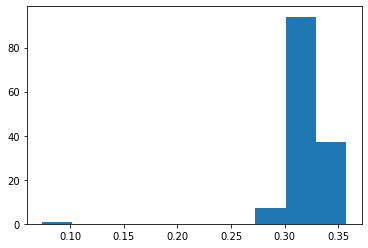

In [81]:
# Generate and display a histogram of the values in memory_footprints using pyplot.hist()
#na ta način s poizkušanjem dobimo optimalno velikost chunka (glede na razpoložljivi pomnilnik)
import matplotlib.pyplot as plt

plt.hist(memory_footprints)
plt.show()

### Counting Across Chunks

In [83]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [84]:
# For each chunk, retrieve the number of rows and add it to num_rows.
num_rows = 0

for chunk in chunk_iter:
    num_rows += len(chunk)

In [85]:
num_rows

34558

### Batch Processing

<img src="./images/process_chunks_count.png">

In [86]:
series_list = [pd.Series([1,2]), pd.Series([2,3])]

pd.concat(series_list)

0    1
1    2
0    2
1    3
dtype: int64

In [87]:
lifespans = []

In [88]:
dtypes = { 'ConstituentBeginDate': 'float',
          'ConstituentEndDate': 'float'}

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", 
                         chunksize=250,
                        dtype=dtypes)

In [90]:
for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)

In [95]:
lifespans_dist = pd.concat(lifespans)

In [96]:
lifespans_dist.head()

250    32.0
251    72.0
252    37.0
253    79.0
254    85.0
dtype: float64

### Optimizing Performance

In [98]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"})

for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)

1.58 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"},  
                         usecols=['ConstituentBeginDate', 'ConstituentEndDate'])

for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])
    
lifespans_dist = pd.concat(lifespans)

486 ms ± 6.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#chunksize je dobro optimizirati tako, da je čimvečji

### Counting Unique Values

<img src="./images/processing_chunks_value_counts.png">

We can use the pandas.concat() function to combine all of the chunks at the end.

In [100]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

In [101]:
overall_vc = []

for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)

In [115]:
combined_vc = pd.concat(overall_vc)
combined_vc.head()

Male      208
Female      9
Male      193
Female      6
Male      195
Name: Gender, dtype: int64

In [116]:
final_vc = combined_vc.groupby(combined_vc.index).sum()

In [117]:
final_vc

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

In [125]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['ExhibitionTitle'])

In [121]:
tt = pd.read_csv("data/MoMAExhibitions1929to1989.csv", nrows=3)
tt.head()

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ConstituentID,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Director,9168,...,NaN,American,1902,1981,"American, 1902–1981",Male,109252853,Q711362,500241556,moma.org/artists/9168
1,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Artist,1053,...,NaN,French,1839,1906,"French, 1839–1906",Male,39374836,Q35548,500004793,moma.org/artists/1053
2,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",11/7/1929,12/7/1929,1,http://www.moma.org/calendar/exhibitions/1767,Artist,2098,...,NaN,French,1848,1903,"French, 1848–1903",Male,27064953,Q37693,500011421,moma.org/artists/2098


In [126]:
overall_title = []

for chunk in chunk_iter:
    chunk_title = chunk['ExhibitionTitle'].value_counts()
    overall_title.append(chunk_title)

In [127]:
combined_title = pd.concat(overall_title)
combined_title.head()

Summer Exhibition: Painting and Sculpture          52
46 Painters and Sculptors under 35 Years of Age    47
Painting and Sculpture by Living Americans         39
German Painting and Sculpture                      28
Painting in Paris                                  26
Name: ExhibitionTitle, dtype: int64

In [128]:
final_title = combined_title.groupby(combined_title.index).sum()

In [132]:
final_title.sort_values(ascending=False).head(10)

Good Design                                                                                       768
Recent Acquisitions                                                                               766
Painting and Sculpture from the Museum Collection                                                 440
Transformations in Modern Architecture                                                            321
The 28th Annual Exhibition of Advertising and Editorial Art of the New York Art Directors Club    302
Painting, Sculpture, Prints                                                                       288
New Horizons in American Art                                                                      284
Photographs from the Museum Collection                                                            276
XXVth Anniversary Exhibition: Paintings from the Museum Collection                                262
20th Century Design from the Museum Collection                                    

### Combining Chunks Using GroupBy

In [ ]:
#rešeno zgoraj

In [ ]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

overall_vc = []

In [ ]:
for chunk in chunk_iter:


## Analizing big files with Pandas and SQLite

In [133]:
import sqlite3

In [134]:
conn = sqlite3.connect('data/moma.db')

In [135]:
moma_iter = pd.read_csv('data/moma.csv', chunksize=1000)

In [136]:
#vse podatke pretvorimo v bazo in potem lahko uporabljamo sql za analize
#kar omogoča delo na večjih datasetih

#za računanje lahko potem uporabljamo pandas ali sql
# - sql_lite dela na disku (mssql pa tudi v ram-u), ne rabi ram-a. pri pandasu pa smo omejeni s pomnilnikom (ampak je hitrejše)
for chunk in moma_iter:
    chunk.to_sql('exhibitions', conn, 
                 if_exists='append', index=False)

### Computing Primarily in SQL

In [137]:
conn = sqlite3.connect('data/moma.db')

In [138]:
q = '''SELECT exhibitionid, count(*) AS counts 
    from exhibitions 
    GROUP BY exhibitionid 
    ORDER BY counts desc;'''

In [139]:
eid_counts = pd.read_sql(q, conn)

In [140]:
conn.close()

In [141]:
eid_counts.head(10)

,ExhibitionID,counts
0,NaN,858
1,7.0,642
2,3838.0,604
3,3030.0,568
4,3988.0,550
5,2600.0,524
6,79.0,518
7,10601.0,512
8,3939.0,508
9,3036.0,488


### Computing Primarily in Pandas

In [142]:
conn = sqlite3.connect('data/moma.db')

In [143]:
q = 'select exhibitionid from exhibitions'

In [144]:
eid_counts = pd.read_sql(q, conn)

In [145]:
conn.close()

In [146]:
eid_counts.head()

,ExhibitionID
0,2557.0
1,2557.0
2,2557.0
3,2557.0
4,2557.0


In [149]:
eid_pandas_counts = eid_counts['ExhibitionID'].value_counts(dropna=False)

In [150]:
eid_pandas_counts.head(10)

NaN        858
7.0        642
3838.0     604
3030.0     568
3988.0     550
2600.0     524
79.0       518
10601.0    512
3939.0     508
3036.0     488
Name: ExhibitionID, dtype: int64

### Reading in SQL Results Using Chunks

In [151]:
conn = sqlite3.connect('data/moma.db')

In [152]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=100)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

2.32 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [153]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=1000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

349 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=10000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

148 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Vaja: Primer analize velikega dataseta

In [155]:
#predpostavimo, da imamo 10 MB pomnilnika
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [156]:
mv_list = []
#preverimo, da chunk-i zadoščajo 10 MB pomnilnika - in so ok
for chunk in chunk_iter:
    print(chunk.memory_usage(deep=True).sum()/(1024*1024))

5.579195022583008
5.528186798095703
5.535004615783691
5.528162956237793
5.5243072509765625
5.553412437438965
5.531391143798828
5.509613037109375
5.396090507507324
4.63945198059082
2.663668632507324


In [159]:
#manjkajoče vrednosti v vsakem stolpcu
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [160]:
na_values = []

for chunk in chunk_iter:
    na_values.append(chunk.isna().sum())

In [164]:
na_values = pd.concat(na_values)

In [169]:
na_values_group = na_values.groupby(na_values.index).sum()

In [173]:
na_values_group.sort_values(ascending=False)

investor_category_code    50427
investor_state_code       16809
investor_city             12480
investor_country_code     12001
raised_amount_usd          3599
company_category_code       643
company_city                533
company_state_code          492
funding_round_type            3
funded_year                   3
funded_month                  3
funded_at                     3
funded_quarter                3
investor_name                 2
investor_permalink            2
investor_region               2
company_region                1
company_permalink             1
company_name                  1
company_country_code          1
dtype: int64

In [174]:
#koliko pomnilnika porabi vsak stolpec posebej
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [176]:
counter = 0
series_memory_fp = pd.Series()

for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
        counter += 1
    else:
        series_memory_fp += chunk.memory_usage(deep=True)

In [178]:
series_memory_fp/(1024*1024)

Index                     0.000877
company_permalink         3.869808
company_name              3.424955
company_category_code     3.262619
company_country_code      3.025223
company_state_code        2.962161
company_region            3.253541
company_city              3.343512
investor_permalink        4.749821
investor_name             3.734270
investor_category_code    0.593590
investor_country_code     2.524654
investor_state_code       2.361876
investor_region           3.238946
investor_city             2.751430
funding_round_type        3.252704
funded_at                 3.378091
funded_month              3.226837
funded_quarter            3.226837
funded_year               0.403366
raised_amount_usd         0.403366
dtype: float64

In [179]:
# Key: Column name, Value: List of types
col_types = {}
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1')

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))
    

In [180]:
#ni vsak chunk istih tipov; tam so verjetno vmes NaN vrednosti:
col_types

{'company_permalink': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_name': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_category_code': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_country_code': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_state_code': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_region': ['object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object',
  'object'],
 'company_city': ['object',
  'object',
  'object',
  'object',
  'object',


In [181]:
unique_col_types = {}

for k, v in col_types.items():
    unique_col_types[k] = set(col_types[k]) #set iz lista vrednosti, ki se lahko ponavljajo, vzame samo unikatne

unique_col_types

{'company_permalink': {'object'},
 'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_permalink': {'object'},
 'investor_name': {'object'},
 'investor_category_code': {'float64', 'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'funded_month': {'object'},
 'funded_quarter': {'object'},
 'funded_year': {'float64', 'int64'},
 'raised_amount_usd': {'float64'}}

In [183]:
import sqlite3
conn = sqlite3.connect('data/crunchbase.db')
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1')

for chunk in chunk_iter:
    chunk.to_sql('investments', conn, 
                if_exists='append', index=False)

In [186]:
q = 'select * from investments limit 5'
data_5 = pd.read_sql(q,conn)
data_5

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,None,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000.0
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000.0
2,/company/utap,uTaP,messaging,USA,None,United States - Other,None,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000.0
3,/company/zoopshop,ZoopShop,software,USA,OH,Columbus,columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-02-15,2012-02,2012-Q1,2012,20000.0
4,/company/efuneral,eFuneral,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2011-09-08,2011-09,2011-Q3,2011,20000.0


VAJA: Which category of company attracted the most investments?

In [187]:
q2 = '''SELECT company_category_code, count(*) AS counts 
    from investments 
    GROUP BY company_category_code 
    ORDER BY counts desc;'''

In [188]:
invest = pd.read_sql(q2,conn)

In [189]:
invest.head()

,company_category_code,counts
0,software,7243
1,web,5015
2,biotech,4951
3,enterprise,4489
4,mobile,4067


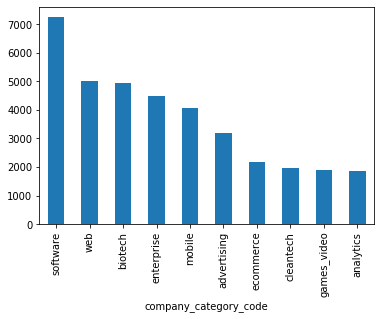

In [191]:
invest.head(10).plot(kind='bar', x='company_category_code', y='counts', legend=False)
plt.show()

## More file formats

- [Big Data file formats](https://luminousmen.com/post/big-data-file-formats)

### [Parquet](https://parquet.apache.org/)

Launched in 2013, Parquet was developed by Cloudera and Twitter to serve as a column-based storage format, optimized for work with multi-column datasets. Because data is stored by columns, it can be highly compressed (compression algorithms perform better on data with low information entropy which is usually contained in columns) and splittable. The developers of the format claim that this storage format is ideal for Big Data problems.

### [Avro](https://avro.apache.org/)

Apache Avro was released by the Hadoop working group in 2009. It is a row-based format that is highly splittable. It also described as a data serialization system similar to Java Serialization. The schema is stored in JSON format while the data is stored in binary format, minimizing file size and maximizing efficiency. Avro has robust support for schema evolution by managing added fields, missing fields, and fields that have changed. This allows old software to read the new data and new software to read the old data — a critical feature if your data has the potential to change.

### [Feather](https://github.com/wesm/feather)

Feather provides binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy. Feather uses the Apache Arrow columnar memory specification to represent binary data on disk. This makes read and write operations very fast. This is particularly important for encoding null/NA values and variable-length types like UTF8 strings.

Feather is a part of the broader Apache Arrow project. Feather defines its own simplified schemas and metadata for on-disk representation.

### [HDF5](https://portal.hdfgroup.org/display/knowledge/What+is+HDF5)

HDF5 is a unique technology suite that makes possible the management of extremely large and complex data collections.

The HDF5 technology suite is designed to organize, store, discover, access, analyze, share, and preserve diverse, complex data in continuously evolving heterogeneous computing and storage environments.

HDF5 supports all types of data stored digitally, regardless of origin or size. Petabytes of remote sensing data collected by satellites, terabytes of computational results from nuclear testing models, and megabytes of high-resolution MRI brain scans are stored in HDF5 files, together with metadata necessary for efficient data sharing, processing, visualization, and archiving.

## Druga zanimiva orodja

### Dask

- [Dokumentacija](https://docs.dask.org/en/latest/)
- [How to handle large datasets in Python with Pandas and Dask](https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55)

<p><em>Dask is a flexible library for parallel computing in Python.</em></p>
<p>Dask is composed of two parts:</p>
    <ol class="arabic simple">
<li><strong>Dynamic task scheduling</strong> optimized for computation. This is similar to
<em>Airflow, Luigi, Celery, or Make</em>, but optimized for interactive
computational workloads.</li>
<li><strong>“Big Data” collections</strong> like parallel arrays, dataframes, and lists that
extend common interfaces like <em>NumPy, Pandas, or Python iterators</em> to
larger-than-memory or distributed environments. These parallel collections
run on top of dynamic task schedulers.</li>
</ol>